In [121]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset,DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt
import statistics
lc=LabelEncoder()
sc = StandardScaler()

In [144]:
df= pd.read_csv('Student_Performance.csv')
df[:5]

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


In [145]:
y=df.iloc[:,-1]
x=df.iloc[:,0:5]
label = lc.fit_transform(df['Extracurricular Activities'])
x.drop('Extracurricular Activities',axis=1,inplace=True)
x['Extracurricular Activities']=list(label)
x=sc.fit_transform(np.array(x))
y=sc.fit_transform(np.array(y).reshape(-1, 1))

In [146]:
Xtrain,Xtest,ytrain,ytest = train_test_split(x,y,test_size=0.2,random_state=42)
Xtest,Xval,ytest,yval = train_test_split(Xtest,ytest,test_size=0.5,random_state=42)

In [147]:
class Customdataset(Dataset):
    def __init__(self,a,b):
        self.x=torch.tensor(a,dtype=torch.float32)
        self.y=torch.tensor(b,dtype=torch.float32)

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        return self.x[index],self.y[index]
    
traindataset=Customdataset(a=Xtrain,b=ytrain)
valdataset=Customdataset(a=Xval,b=yval)
testdataset=Customdataset(a=Xtest,b=ytest)

traindl=DataLoader(traindataset,batch_size=16,shuffle=True)
testdl=DataLoader(testdataset,batch_size=16,shuffle=True)
valdl=DataLoader(valdataset,batch_size=16,shuffle=True)

In [178]:
class regression(nn.Module):
    def __init__(self):
        super(regression,self).__init__()
        self.Linear1=nn.Linear(x.shape[1],24)
        self.Linear2=nn.Linear(24,1)

    def forward(self,x):
        x=self.Linear1(x)
        x = torch.relu(x)
        x=self.Linear2(x)
        return x

model=regression()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-5)
critetion=nn.MSELoss()

In [179]:
train_acc,train_loss=[],[]
val_acc,val_loss=[],[]
epoches = 2
for i in range(epoches):
    l1,l2=0,0
    model.train()
    ta,tl=[],[]
    for values,labels in traindl:
        ypred = model(values)
        tloss = critetion(ypred,labels)
        optimizer.zero_grad()
        tloss.backward()        
        optimizer.step()
        l1=labels.unsqueeze(1)
        tl.append(int(tloss.detach().numpy()))
        ta.append(root_mean_squared_error(l1.view(-1),ypred.detach().numpy()))
    train_acc.append(statistics.mean(ta))
    train_loss.append(statistics.mean(tl))
    # print('trian')
    # print(mean_absolute_error(l1,ypred.detach().numpy()))  
    # print(tloss)
    va,vl = [],[]
    model.eval()   
    with torch.no_grad():
        for values,labels in valdl:
            ypred = model(values)
            tloss = critetion(ypred,labels)
            l2=labels.unsqueeze(1)
            vl.append(int(tloss.detach().numpy()))
            va.append(root_mean_squared_error(l2.view(-1),ypred.detach().numpy()))
        val_acc.append(statistics.mean(va))
        val_loss.append(statistics.mean(vl))
        # print('test')
        # print(mean_absolute_error(l2,ypred.detach().numpy()))
        # print(tloss)

                

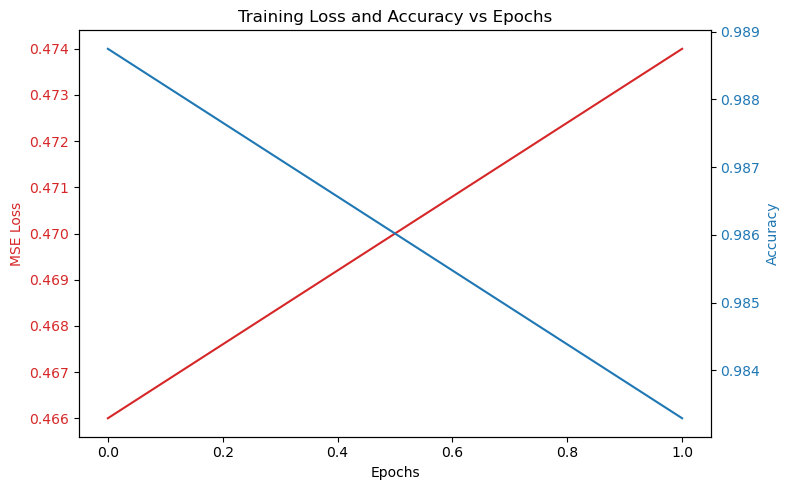

In [180]:
# train_acc1,train_loss1 = sc.fit_transform(train_acc.reshape(-1, 1)),sc.fit_transform(train_loss.reshape(-1, 1))
fig, ax1 = plt.subplots(figsize=(8, 5))
ax1.plot(range(epoches), train_loss, color='tab:red', label='Loss')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("MSE Loss", color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')
ax2 = ax1.twinx()
ax2.plot(range(epoches), train_acc, color='tab:blue', label='Accuracy')
ax2.set_ylabel("Accuracy", color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')
plt.title("Training Loss and Accuracy vs Epochs")
fig.tight_layout()
plt.show()

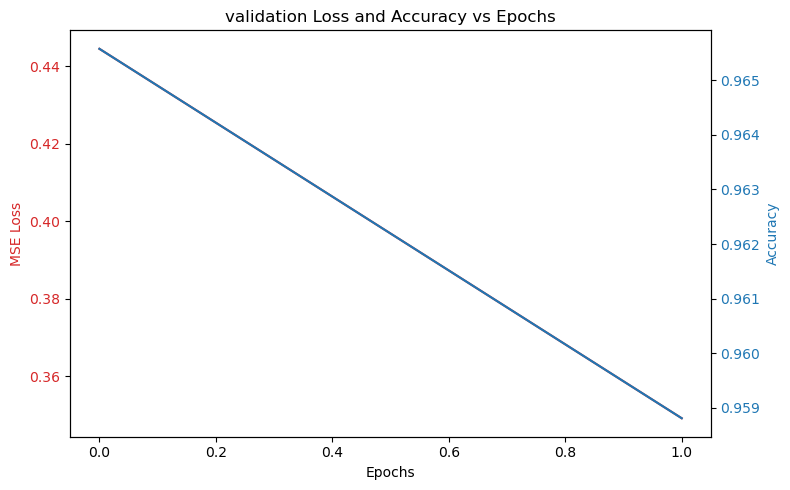

In [181]:
fig, ax1 = plt.subplots(figsize=(8, 5))
ax1.plot(range(epoches), val_loss, color='tab:red', label='Loss')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("MSE Loss", color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')
ax2 = ax1.twinx()
ax2.plot(range(epoches), val_acc, color='tab:blue', label='Accuracy')
ax2.set_ylabel("Accuracy", color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')
plt.title("validation Loss and Accuracy vs Epochs")
fig.tight_layout()
plt.show()

c:\Users\ASUS\.conda\envs\PyTorch\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([16, 1, 1])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\ASUS\.conda\envs\PyTorch\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([8, 1, 1])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


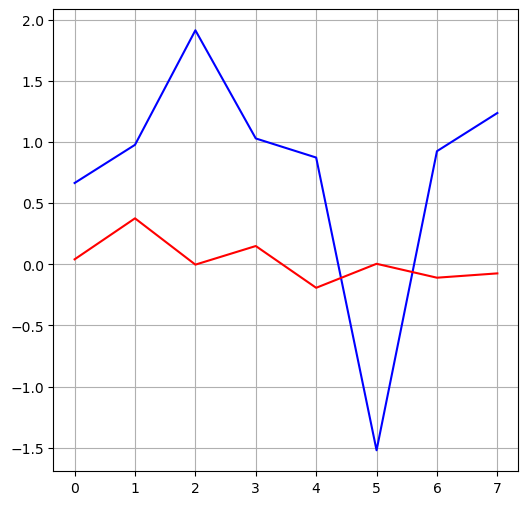

In [182]:
model.eval()   
with torch.no_grad():
    for values,labels in testdl:
        ypred = model(values)
        tloss = critetion(ypred,labels.unsqueeze(1))
plt.figure(figsize=(6,6))
plt.plot(labels.numpy(),color='blue')
plt.plot(ypred.numpy(),color='red')
plt.grid(True)
plt.show()

In [183]:
print(values)
print(labels)
print(ypred)
print(tloss)

tensor([[-0.3835,  0.7816,  0.8665, -1.5985, -0.9897],
        [ 1.1614,  0.6663, -0.3129, -1.2498,  1.0105],
        [ 0.3890,  1.7042,  0.8665,  0.4941,  1.0105],
        [-0.3835,  1.0122, -0.9026,  1.5404,  1.0105],
        [-0.3835,  1.1852,  1.4562,  0.4941,  1.0105],
        [-1.5421, -1.0636,  0.8665, -1.5985,  1.0105],
        [ 0.0027,  0.8969,  1.4562, -0.2034, -0.9897],
        [ 0.0027,  1.4159,  0.2768,  1.1916,  1.0105]])
tensor([[ 0.6650],
        [ 0.9773],
        [ 1.9142],
        [ 1.0293],
        [ 0.8732],
        [-1.5212],
        [ 0.9252],
        [ 1.2375]])
tensor([[ 0.0407],
        [ 0.3760],
        [-0.0027],
        [ 0.1495],
        [-0.1922],
        [ 0.0041],
        [-0.1096],
        [-0.0743]])
tensor(1.4391)
